### Introduction

In [2]:
import os
import sys
import json
import numpy as np
import torch
torch.set_default_dtype(torch.float64)
import sklearn
from sklearn.datasets import make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process as gp_sklearn
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, HMC, NUTS
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
import pyro.contrib.gp as gp
import matplotlib.pyplot as plt
import seaborn as sns

/home/macro/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


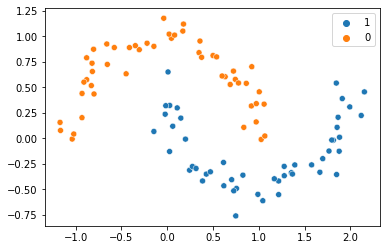

In [3]:
x, y = make_moons(n_samples=100, shuffle=True, noise=0.1, random_state=1)
x = torch.from_numpy(x)
y = torch.from_numpy(y).double()
def scatterplot(x, y):
 colors = np.array(['0', '1'])
 sns.scatterplot(x[:, 0], x[:, 1], hue=colors[y.int()])

scatterplot(x, y)

### 1

In [6]:
# define kernel
kernel_RBF = gp_sklearn.kernels.RBF(length_scale=torch.tensor(1.))

# gp classifier
gpr = GaussianProcessClassifier(kernel_RBF)

# fit to data
gpr.fit(x, y)

GaussianProcessClassifier(kernel=RBF(length_scale=1))

### 2

In [20]:
def meshgrid(x, n, eps=0.1):
 x0, x1 = np.meshgrid(np.linspace(x[:, 0].min()-eps, x[:, 0].max()+eps, n),
 np.linspace(x[:, 1].min()-eps, x[:, 1].max()+eps, n))
 x_grid = np.stack([x0.ravel(), x1.ravel()], axis=-1)
 return x0, x1, x_grid
 
def plot_sklearn_predictions(sklearn_gp_classifier, x, y):
 x0, x1, x_grid = meshgrid(x, 30)
 preds = sklearn_gp_classifier.predict_proba(x_grid)
 preds_0 = preds[:,0].reshape(x0.shape)
 preds_1 = preds[:,1].reshape(x0.shape)
 plt.figure(figsize=(10,6))
 plt.contourf(x0, x1, preds_0, 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
 plt.contourf(x0, x1, preds_1, 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
 plt.title(f'Posterior Mean')
 plt.xticks([]); plt.yticks([])
 plt.colorbar()
 scatterplot(x, y)

/home/macro/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


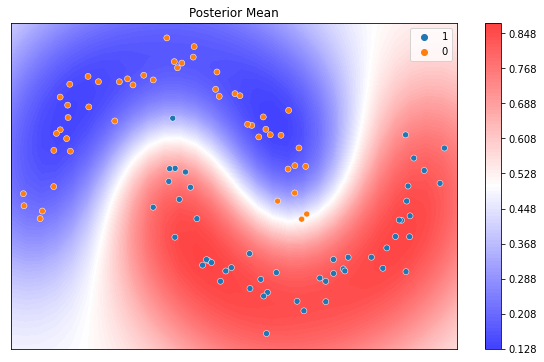

In [21]:
# plot 
plot_sklearn_predictions(gpr, x, y)

### 3

In [30]:
def get_logits(x, mu, sigma, l, eta):
 kernel = gp.kernels.RBF(input_dim=2, variance=torch.tensor(sigma),
 lengthscale=torch.tensor(l))
 K = kernel.forward(x, x) + torch.eye(x.shape[0]) * 1e-6
 L = K.cholesky()
 return mu+torch.mv(L,eta)

def sample_logit(x, mu, sigma, l, eta):
    logits = get_logits(x, mu, sigma, l, eta)

In [33]:
# classifier
def gp_classifier(x, y, fun):
    n_samples = len(x)
    mu = pyro.sample('mu', dist.Normal(0, 1))
    sigma = pyro.sample('sigma', dist.LogNormal(0,1))
    l = pyro.sample('l', dist.LogNormal(0,1))

    with pyro.plate('N', n_samples):
        eta = pyro.sample('eta', dist.Normal(0,1))
        logit_p = fun(x, mu, sigma, l, eta)
        y_pred = pyro.sample('y', dist.Bernoulli(torch.sigmoid(logit_p)), obs=y)


In [34]:
# NUTS
kernel = NUTS(gp_classifier, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(kernel, num_samples=10, warmup_steps=50)
mcmc.run(x, y, get_logits)

Warmup:   0%|          | 0/60 [00:00, ?it/s]<ipython-input-30-90c2a6982bd7>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel = gp.kernels.RBF(input_dim=2, variance=torch.tensor(sigma),
<ipython-input-30-90c2a6982bd7>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengthscale=torch.tensor(l))
<ipython-input-30-90c2a6982bd7>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel = gp.kernels.RBF(input_dim=2, variance=torch.tensor(sigma),
<ipython-input-30-90c2a6982bd7>:3: UserWarning: To copy construct from a tensor, it is recomme

In [39]:
def posterior_predictive(samples, i, x, x_grid):
 kernel = gp.kernels.RBF(input_dim=2, variance=samples['sigma'][i],
 lengthscale=samples['l'][i])
 N_grid = x_grid.shape[0]

 y = get_logits(x, samples['mu'][i], samples['sigma'][i],
 samples['l'][i], samples['eta'][i])

 with torch.no_grad():
    gpr = gp.models.GPRegression(x, y, kernel=kernel)
    mean, cov = gpr(x_grid, full_cov=True)

 yhat = dist.MultivariateNormal(mean, cov + torch.eye(N_grid) * 1e-6).sample()
 return yhat.sigmoid().numpy()

def plot_pyro_predictions(posterior_samples, x):
 n_samples = posterior_samples['sigma'].shape[0]
 x0, x1, x_grid = meshgrid(x, 30)
 x_grid = torch.from_numpy(x_grid)
 preds = np.stack([posterior_predictive(posterior_samples, i, x, x_grid) for i in range(n_samples)])
 plt.figure(figsize=np.array([10, 6]))
 plt.contourf(x0, x1, preds.mean(0).reshape(x0.shape), 101,
 cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
 plt.title(f'Posterior Mean')
 plt.xticks([]); plt.yticks([])
 plt.colorbar()
 scatterplot(x, y)

In [43]:
# get posterior samples
posterior_samples = mcmc.get_samples()

<ipython-input-30-90c2a6982bd7>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel = gp.kernels.RBF(input_dim=2, variance=torch.tensor(sigma),
<ipython-input-30-90c2a6982bd7>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengthscale=torch.tensor(l))
/home/macro/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


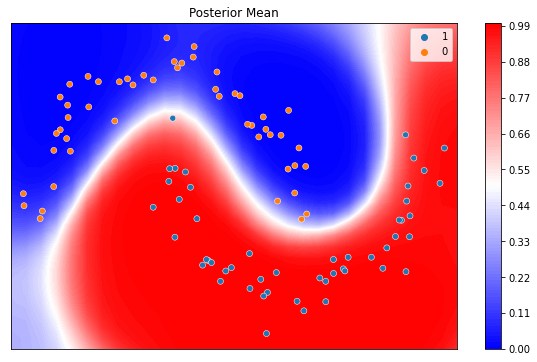

In [44]:
# plot predctions from posterior
plot_pyro_predictions(posterior, x)